![](alerce_logo.png)

# Organizing observations for a list of nearby SNe

`Author: Francisco Förster, Last update: 20210407`

In this example we will do two things:

1. query for a sample of young SN candidates located within a nearby galaxy
2. query a sample of SNe recently detected, and use our forecasting tool to organize observations in a given night.

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os, sys, re

In [3]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [4]:
import psycopg2

In [5]:
!pip install alerce

You should consider upgrading via the '/home/fforster/anaconda3/bin/python -m pip install --upgrade pip' command.


In [6]:
from alerce.core import Alerce
alerce = Alerce()

In [7]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [8]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import get_sun

In [9]:
from scipy.interpolate import interp1d

# Look for SN candidates in nearby galaxies

## Morphologically classified catalog (Ann & Seo 2015)

https://arxiv.org/pdf/1502.03545.pdf

In [10]:
gal_morph = pd.read_csv("https://github.com/alercebroker/usecases/blob/master/example_data/MorphGal.dat?raw=true", sep="\s+")
gal_morph.head()

,objid,ra,dec,z,Morph,T,Distance,rMag,umr,amaj,b_a,name
0,587730773888860441,0.264999,14.580184,0.005718,Im/BCD,12,25.27,-15.03,0.59,25.9,0.68,SDSSJ000103.59+143448.6
1,587727223561388187,0.812671,16.145773,0.003516,SAa,1,16.47,-19.92,3.42,342.5,0.30,NGC7814
2,587727222487646439,0.929659,15.217976,0.002929,SAdm,8,14.13,-15.67,1.93,90.5,0.51,UGC00017
3,587727223025106954,2.193413,15.815708,0.002885,Im,10,13.94,-17.81,1.33,97.4,0.84,NGC0014
4,587727220877623551,2.203321,14.033716,0.006300,Sm/Im,10,27.56,-15.14,1.44,48.2,0.27,SDSSJ000848.74+140204.0


## Perform a query for young SNe within two semimajor axis of one of the previous nearby galaxies

Load credentials

In [11]:
import requests
# use the location of your credentials file here
credentials_file = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(credentials_file).json()["params"]

In [12]:
conn = psycopg2.connect(dbname=params["dbname"], user=params["user"], host=params["host"], password=params["password"])

Build a string with the galaxy names and coordinates

In [13]:
gal_str = ",\n".join(gal_morph.loc[gal_morph.amaj > 60].apply(lambda row: "(%s, %s, %s, %s)" % (row.name, row.ra, row.dec, row.amaj), axis=1).values) # note that index is called as row.name, the name column should be called row["name"]

In [14]:
from astropy.time import Time
nt = Time.now()
first_mjd_discovery = Time("2021-03-01").mjd
last_mjd_discovery = Time("2021-04-01").mjd
ndetmin = 5
search_radius = 2. * gal_morph.amaj.max() / 3600 # degrees

In [15]:
query = """
WITH catalog ( gal_id, ra, dec, amaj) AS (
    VALUES
        {values}
),
sn (oid, classifier_name, classifier_version, class_name, probability, ranking) AS (
    SELECT
        o.oid, p.classifier_name, p.classifier_version, p.class_name, p.probability, p.ranking
    FROM
        probability p
    INNER JOIN 
        object o
    ON 
        o.oid=p.oid
    WHERE
        p.classifier_name='stamp_classifier'
        AND classifier_version='stamp_classifier_1.0.4' -- This version is active since March 2021
        AND p.class_name IN ('SN')
        AND p.ranking=1
        AND p.probability > 0.4
        AND o.firstmjd > {first_mjd_discovery}
        AND o.firstmjd < {last_mjd_discovery}
        AND o.ndet > {ndetmin}
)

SELECT 
    c.gal_id, c.ra, c.dec, c.amaj, o.oid, o.meanra, o.meandec, q3c_dist(c.ra,c.dec,o.meanra,o.meandec), 
    o.firstmjd, sn.classifier_name, sn.class_name, sn.classifier_version, sn.probability, sn.ranking

FROM object o INNER JOIN sn ON sn.oid=o.oid, catalog c
    /*
     * It is REALLY important to first use the catalog then the object ra,dec for speed. The radius is in degrees.
     */
WHERE
    q3c_join(c.ra, c.dec,o.meanra, o.meandec, {radius})
    AND q3c_dist(c.ra,c.dec,o.meanra,o.meandec) < (2 * c.amaj / 3600)
ORDER BY
    c.gal_id
""" 

query_str = query.format(values=gal_str, radius=search_radius, 
                         first_mjd_discovery = first_mjd_discovery,
                         last_mjd_discovery = last_mjd_discovery,
                         ndetmin=ndetmin) # radius in degrees

~10 seconds

In [16]:
matches = pd.read_sql(query_str,conn)

We will inherit some columns from the catalog dataframe

In [17]:
matches["q3c_dist"] = matches.q3c_dist * 3600 # transform to arcsec
for key in ["z", "Distance", "name", "Morph"]:
    matches[key] = gal_morph.loc[matches.gal_id][key].values
print(matches.shape)
matches

(6, 18)


,gal_id,ra,dec,amaj,oid,meanra,meandec,q3c_dist,firstmjd,classifier_name,class_name,classifier_version,probability,ranking,z,Distance,name,Morph
0,1252,159.691056,53.503378,183.9,ZTF21aaqgmjt,159.696986,53.508428,22.174875,59293.242107,stamp_classifier,SN,stamp_classifier_1.0.4,0.855460,1,0.003309,10.66,NGC3310,SAcd
1,2453,181.763038,43.065663,205.2,ZTF21aanzcuj,181.771809,42.988431,278.989943,59278.312535,stamp_classifier,SN,stamp_classifier_1.0.4,0.697352,1,0.002692,8.34,NGC4111,SA0
2,2584,183.049144,13.246514,110.4,ZTF21aaqhhfu,183.042902,13.249180,23.885975,59293.235347,stamp_classifier,SN,stamp_classifier_1.0.4,0.757625,1,0.006211,16.67,NGC4165,SABa
3,2589,183.071942,13.205199,186.9,ZTF21aaqhhfu,183.042902,13.249180,188.217745,59293.235347,stamp_classifier,SN,stamp_classifier_1.0.4,0.757625,1,0.007725,28.44,NGC4168,E
4,3196,186.427333,7.216654,282.9,ZTF21aaqytjr,186.423654,7.228401,44.282435,59303.358900,stamp_classifier,SN,stamp_classifier_1.0.4,0.783118,1,0.003322,16.67,IC3322A,Scd
5,5356,226.623464,55.763645,443.6,ZTF21aasqxqw,226.837720,55.766481,434.055442,59291.494676,stamp_classifier,SN,stamp_classifier_1.0.4,0.434446,1,0.002242,7.83,NGC5866,SAB0


And we will show the available candidates in the ALeRCE explorer. You will see a list of candidates, once you click on one, you can move between candidates using the keyboard arrows :)

In [18]:
url = "https://alerce.online/?" + "&".join(["oid=%s" % oid for oid in matches.iloc[:100].oid.values]) + "&count=true&page=1&perPage=1000&sortDesc=false"
print(url)

https://alerce.online/?oid=ZTF21aaqgmjt&oid=ZTF21aanzcuj&oid=ZTF21aaqhhfu&oid=ZTF21aaqhhfu&oid=ZTF21aaqytjr&oid=ZTF21aasqxqw&count=true&page=1&perPage=1000&sortDesc=false


# Use the forecasting tool to program observations

## We will look for supernova candidates discovered during February and with at least 20 detections in order to plan some observations

We now do a simpler query based on the light curve classifier probabilities and the number of detections required.

In [19]:
query = """
SELECT
    o.oid, o.ndet, o.meanra, o.meandec, p.classifier_name, p.classifier_version, p.class_name, p.probability, p.ranking
FROM
    probability p
INNER JOIN 
    object o
ON 
    o.oid=p.oid
WHERE
    p.classifier_name='lc_classifier'
    AND p.class_name IN ('SNIa', 'SNIbc', 'SNII', 'SLSN')
    AND ranking=1
    AND p.probability > 0.4
    AND o.firstmjd > {first_mjd_discovery}
    AND o.firstmjd < {last_mjd_discovery}
    AND o.ndet > {ndetmin}
ORDER BY
    p.probability DESC
""" 
#    AND q3c_dist(c.ra,c.dec,o.meanra,o.meandec) < (amaj / 3600)
#        AND p.class_name IN ('SN')

query_str = query.format(first_mjd_discovery = (Time.now() - 70 * u.day).mjd,
                         last_mjd_discovery = (Time.now() - 40 * u.day).mjd,
                         ndetmin=30) # radius in degrees

In [20]:
matches = pd.read_sql(query_str,conn)
matches

,oid,ndet,meanra,meandec,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF21aagolqa,32,158.071278,43.659177,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.501984,1
1,ZTF21aahfjlo,34,214.649188,52.101107,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.463072,1
2,ZTF21aagmqic,35,96.512302,86.690487,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.460000,1
3,ZTF21aalhtgv,32,157.177272,-11.042817,lc_classifier,hierarchical_random_forest_1.0.0,SLSN,0.456896,1
4,ZTF21aamwzfi,39,252.617110,58.243631,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.451440,1
5,ZTF21aakyqkb,34,113.802473,14.850963,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.441116,1
6,ZTF21aagogqe,34,132.666576,13.168812,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.438240,1
7,ZTF21aagtuzm,47,236.633262,22.537449,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.438240,1
8,ZTF21aalgszc,55,162.600634,0.926911,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.436248,1
9,ZTF21aagnzjy,49,146.280432,68.591517,lc_classifier,hierarchical_random_forest_1.0.0,SNII,0.428016,1


Let's close the connection to the DB

In [21]:
conn.close()

### Check in the ALeRCE explorer!

In [22]:
url = "https://alerce.online/?" + "&".join(["oid=%s" % oid for oid in matches.oid.values]) + "&count=true&page=1&perPage=1000&sortDesc=false"
print(url)

https://alerce.online/?oid=ZTF21aagolqa&oid=ZTF21aahfjlo&oid=ZTF21aagmqic&oid=ZTF21aalhtgv&oid=ZTF21aamwzfi&oid=ZTF21aakyqkb&oid=ZTF21aagogqe&oid=ZTF21aagtuzm&oid=ZTF21aalgszc&oid=ZTF21aagnzjy&oid=ZTF21aagocor&oid=ZTF21aamfcji&oid=ZTF21aahfjrr&oid=ZTF21aambclf&oid=ZTF21aalinof&oid=ZTF21aamhtui&oid=ZTF21aalkknw&oid=ZTF21aagsysd&count=true&page=1&perPage=1000&sortDesc=false


## Use the forecast API to do predict the evolution of the previous sample

In [23]:
def get_forecasts(oid, times):
    print("Getting forecasts for %s..." % oid)
    forecasts = []
    url = "https://api.alerce.online/forecast/v1/parametric/sn?oid=%s&%s" % (oid, "&".join(["mjd=%s" % mjd for mjd in times]))
    response = requests.get(url)
    return pd.DataFrame(response.json()["forecast"]).apply(pd.Series.explode)

And let's write a function to plot the observed vs forecasted data

In [24]:
def plot_SN(oid, det, non_det, pred, obsdate=None):
    fig, ax = plt.subplots()
    colors = {1: 'g', 2: 'r'}
    for fid in det.fid.unique():
        mask = det.fid == fid
        ax.errorbar(det.loc[mask].mjd, det.loc[mask].magpsf, yerr=det.loc[mask].sigmapsf, c=colors[fid], marker='o', lw=0, elinewidth=1, label=colors[fid])
        mask_f = pred.fid == fid
        ax.plot(pred.loc[mask_f].mjd.values, np.array(pred.loc[mask_f].magpsf.values), c=colors[fid], ls=":")
    if not non_det.empty:
        for fid in non_det.fid.unique():
            mask = non_det.fid == fid
            ax.scatter(non_det.loc[mask].mjd, non_det.loc[mask].diffmaglim, c=colors[fid], marker='v', alpha=0.3)
    ax.set_ylim(min(22, ax.get_ylim()[1]), ax.get_ylim()[0])
    ax.set_xlabel("MJD")
    ax.set_ylabel("mag")
    ax.set_title(oid)
    # if we want to look at a particular time
    if not obsdate is None:
        ax.axvline(Time(obsdate).mjd, c='gray', ls=":", label=obsdate)
    plt.legend()
    plt.show()
    plt.close()

We will focus our attention on a particular date:

In [25]:
obsdate = "2021-04-21"

Now we will iterate over the previous SNe to see how the forecasting is doing. We will build interpolating functions for every object and filter, stored in the dictionary `snpred[oid][fid]`.

*WARNING*: The forecasting tool is a beta version.

Getting forecasts for ZTF21aagolqa...


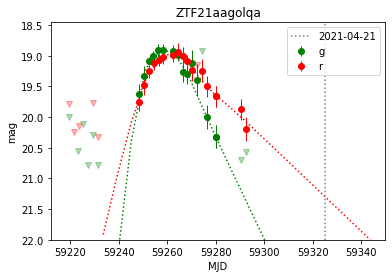

Getting forecasts for ZTF21aahfjlo...


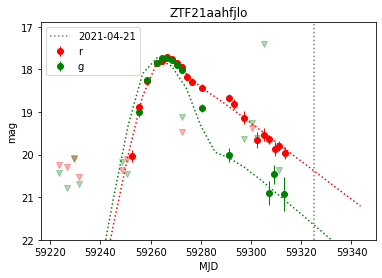

Getting forecasts for ZTF21aagmqic...


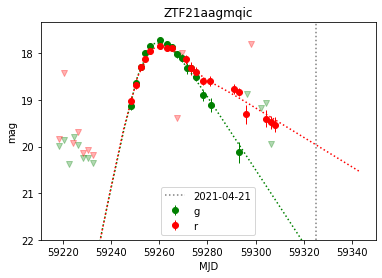

Getting forecasts for ZTF21aalhtgv...


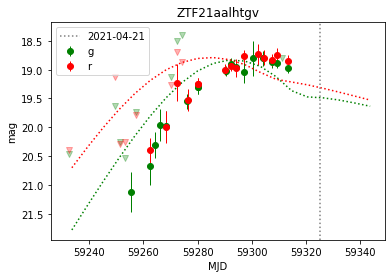

Getting forecasts for ZTF21aamwzfi...


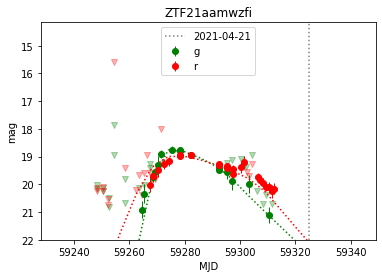

Getting forecasts for ZTF21aakyqkb...


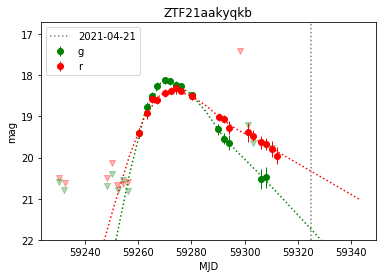

Getting forecasts for ZTF21aagogqe...


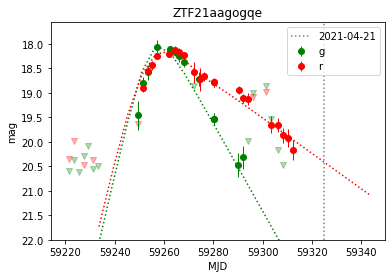

Getting forecasts for ZTF21aagtuzm...


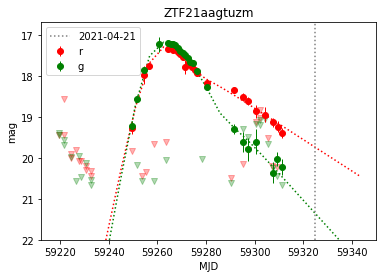

Getting forecasts for ZTF21aalgszc...


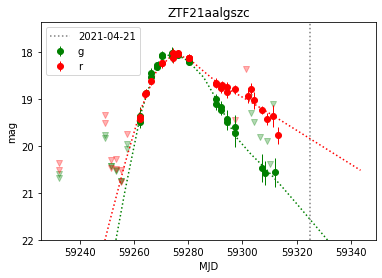

Getting forecasts for ZTF21aagnzjy...


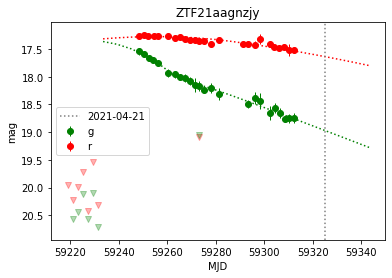

Getting forecasts for ZTF21aagocor...


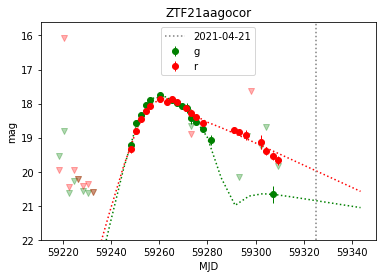

Getting forecasts for ZTF21aamfcji...


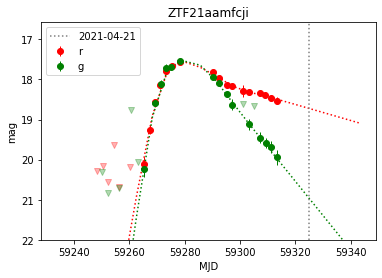

Getting forecasts for ZTF21aahfjrr...


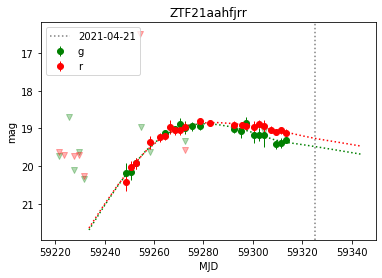

Getting forecasts for ZTF21aambclf...


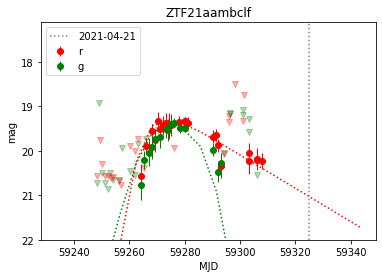

Getting forecasts for ZTF21aalinof...


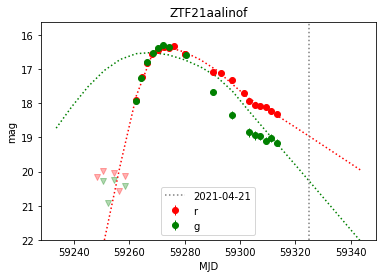

Getting forecasts for ZTF21aamhtui...


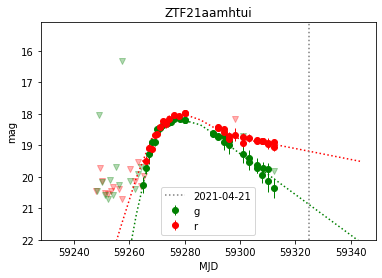

Getting forecasts for ZTF21aalkknw...


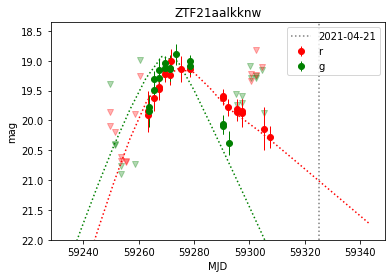

Getting forecasts for ZTF21aagsysd...


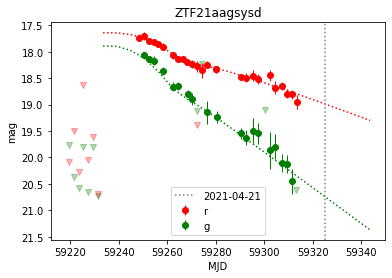

In [28]:
ts = np.linspace((Time.now() - 80 * u.day).mjd, (Time.now() + 30 * u.day).mjd, 20)
snpred = {}
for oid in matches.oid:
    snpred[oid] = {}
    det = alerce.query_detections(oid, format='pandas')
    non_det = alerce.query_non_detections(oid, format='pandas')
    pred = get_forecasts(oid, ts)
    for fid in det.fid.unique():
        snpred[oid][fid] = interp1d(ts, pred.loc[pred.fid==fid].magpsf)
    plot_SN(oid, det, non_det, pred, obsdate)

This is the beta version of our forecasting tool, **please use with caution**. It does not do a good job at early times, and is not perfect at late times either. We will include many more methods in the future. Stay tuned!

Now we will use the previous forecasts to program observations at a telescope.

## Plot the airmass evolution with expected magnitudes on a given date

We will now use the previous interpolation functions to study the airmass and magnitudes of the previous sample of SNe. Let's say we have a full night of observations on 2021-04-15.

Define a location (let's use the location of the Vera C. Rubin Observatory!)

In [33]:
site_name = "Magellan"
site = EarthLocation(lat=-29.015*u.deg, lon=-70.6917*u.deg, height=2516*u.m)

Look for times between sunset and sunrise

In [34]:
utcoffset = -4 * u.hour
midnight = Time("%sT00:00:00" % obsdate) - utcoffset
delta_midnight = np.linspace(-12, 12, 1000)*u.hour
times = midnight + delta_midnight
altazframe = AltAz(obstime=times, location=site)
sunalts = np.array(get_sun(times).transform_to(altazframe).alt / u.deg)
times = times[sunalts < -10] # consider only times when Sun is below 10 degrees from the horizon
altazframe = AltAz(obstime=times, location=site)
sunalts = np.array(get_sun(times).transform_to(altazframe).alt / u.deg)

Iterate over the previous sources to get the airmass evolution, color coding the magnitudes

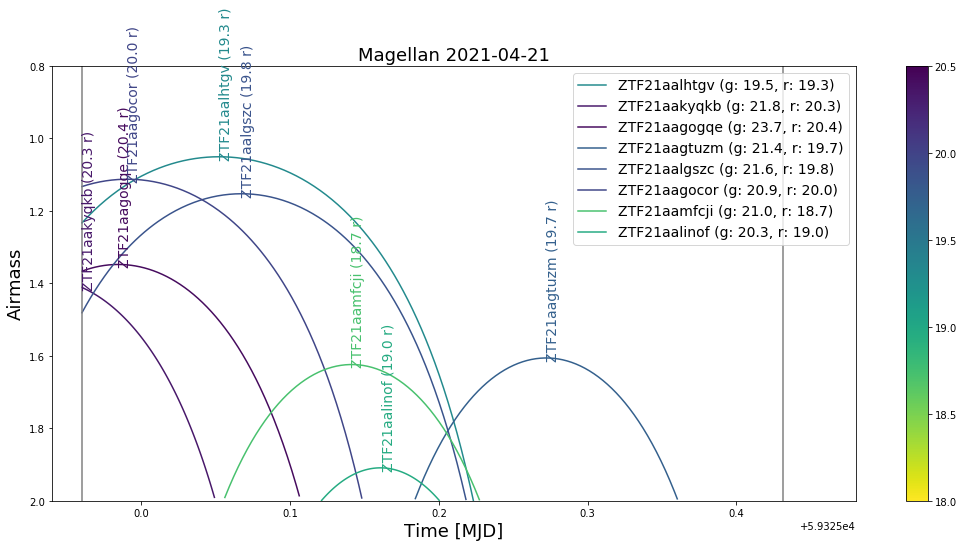

In [35]:
maglim = 20.5
altlim = 30 # minimum number of degrees below the horizon
sn_selected = []

cmap = plt.get_cmap('viridis_r') # jet                                                                                                                                                                        
norm  = colors.Normalize(vmin = 18, vmax = maglim)
scalarMap = cmx.ScalarMappable(norm = norm, cmap = cmap)

fig, ax = plt.subplots(figsize=(18, 8))
for index, row in matches.iterrows():
    sn = SkyCoord(ra=row.meanra*u.deg, dec=row.meandec*u.deg)
    snt = sn.transform_to(AltAz(obstime=times, location=site))
    mask = snt.alt/u.deg > altlim
    # skip objects which are never above 30 degrees from the horizon
    if np.sum(mask) == 0:
        continue
    sn_selected.append(row.oid)
    mag_g = snpred[row.oid][1](midnight.mjd)
    mag_r = snpred[row.oid][2](midnight.mjd)
    # only show objects whose g or r magnitude is below 20.5
    if mag_g < 20.5 or mag_r < 20.5:
        colorVal = scalarMap.to_rgba(min(mag_g, mag_r))
        ax.plot(times[mask].mjd, snt[mask].secz, label="%s (g: %.1f, r: %.1f)" % (row.oid, mag_g, mag_r), c=colorVal)
        idxmax = np.argmin(np.array(snt[mask].secz))
        # only label those below 20 mag
        best = "g" if mag_g < mag_r else "r"
        ax.text(times[mask][idxmax].mjd, snt[mask][idxmax].secz, "%s (%.1f %s)" % (row.oid, min(mag_g, mag_r), best), fontsize=14, c=colorVal, rotation=90)
ax.set_ylim(2, 0.8)
ax.set_xlabel("Time [MJD]", fontsize=18)
ax.set_ylabel("Airmass", fontsize=18)
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 0.1)
ax.axvline(min(times.mjd), c='gray')
ax.axvline(max(times.mjd), c='gray')
ax.set_title("%s %s" % (site_name, obsdate), fontsize=18)
fig.colorbar(cmx.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
plt.legend(fontsize=14, loc=1)

Now you could use your favorite method to find your optimal schedule.

## Let's generate a link to be used during the night of observations 
Very useful for tired astronomers :)

In [36]:
url = "https://alerce.online/?" + "&".join(["oid=%s" % oid for oid in sn_selected]) + "&count=true&page=1&perPage=1000&sortDesc=false"
print(url)

https://alerce.online/?oid=ZTF21aalhtgv&oid=ZTF21aakyqkb&oid=ZTF21aagogqe&oid=ZTF21aagtuzm&oid=ZTF21aalgszc&oid=ZTF21aagocor&oid=ZTF21aamfcji&oid=ZTF21aalinof&oid=ZTF21aalkknw&count=true&page=1&perPage=1000&sortDesc=false
